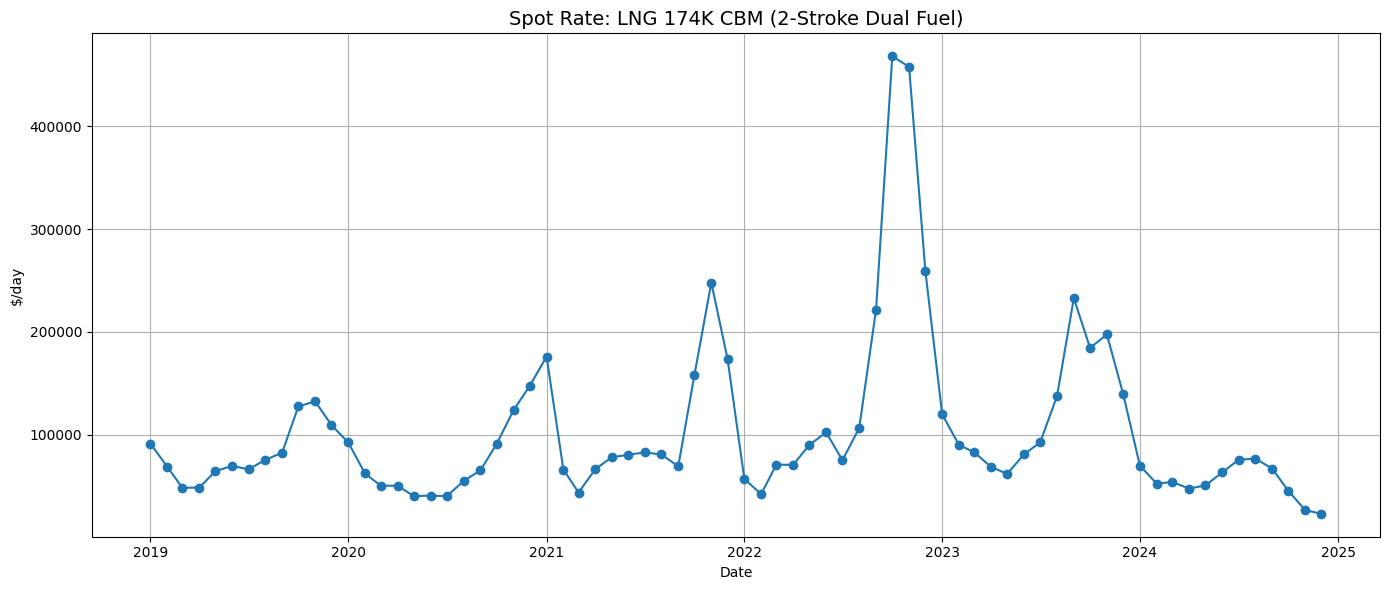

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare the data
df = pd.read_csv("cleandata.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%b-%Y')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Plotting the spot rate time series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'], marker='o')
plt.title("Spot Rate: LNG 174K CBM (2-Stroke Dual Fuel)", fontsize=14)
plt.ylabel("$/day")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


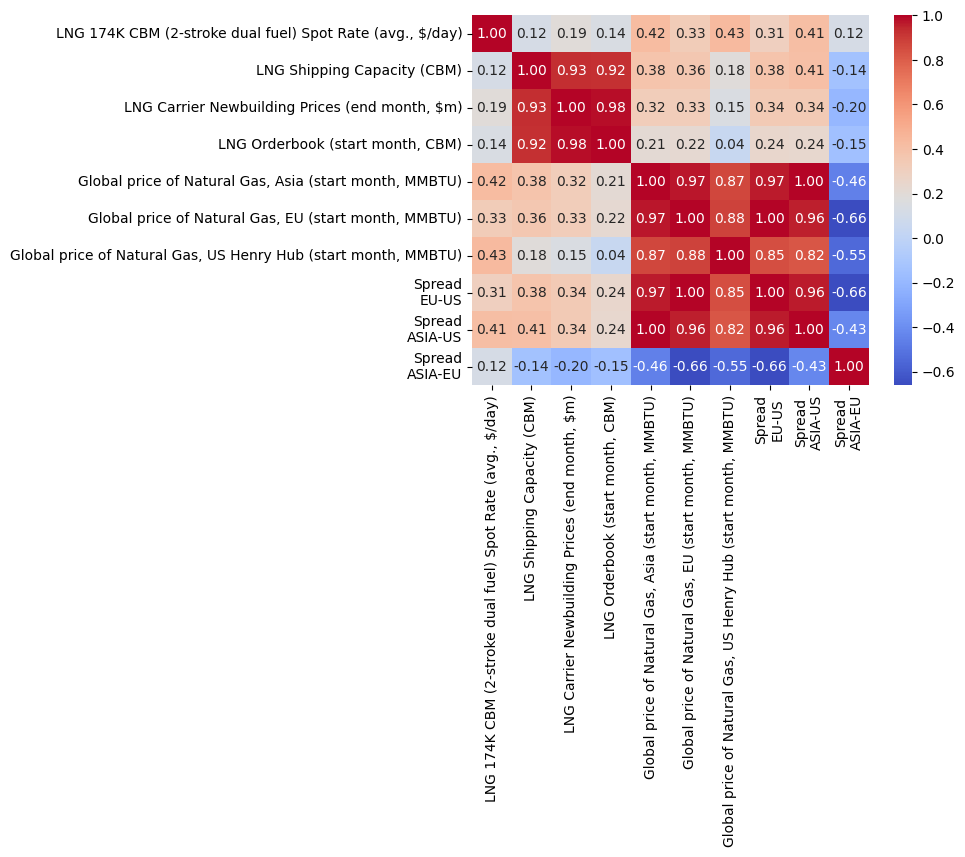

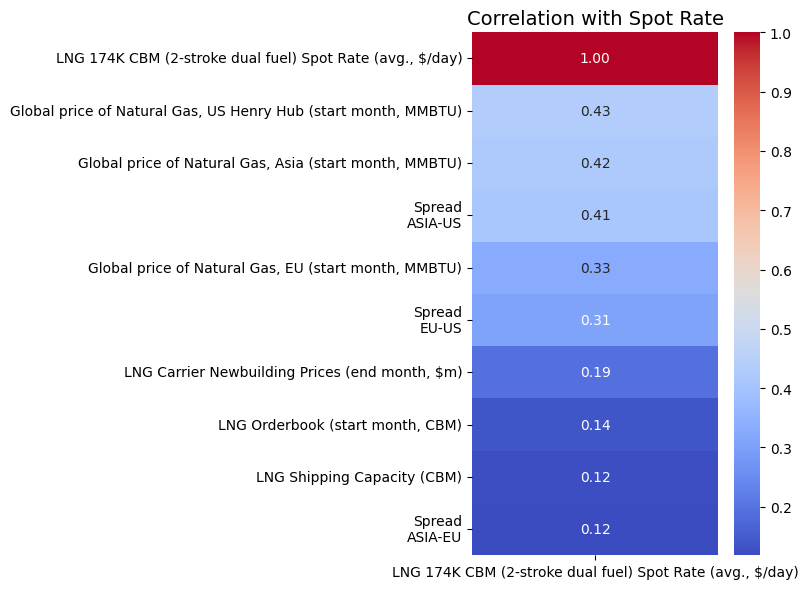

In [6]:
import seaborn as sns

# Compute correlation matrix
correlation_matrix = df.corr()
#display(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

# Focus on correlation with the target (spot rate)
target = 'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'
correlations = correlation_matrix[[target]].sort_values(by=target, ascending=False)
#print(correlations)
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation with Spot Rate", fontsize=14)
plt.tight_layout()
plt.show()


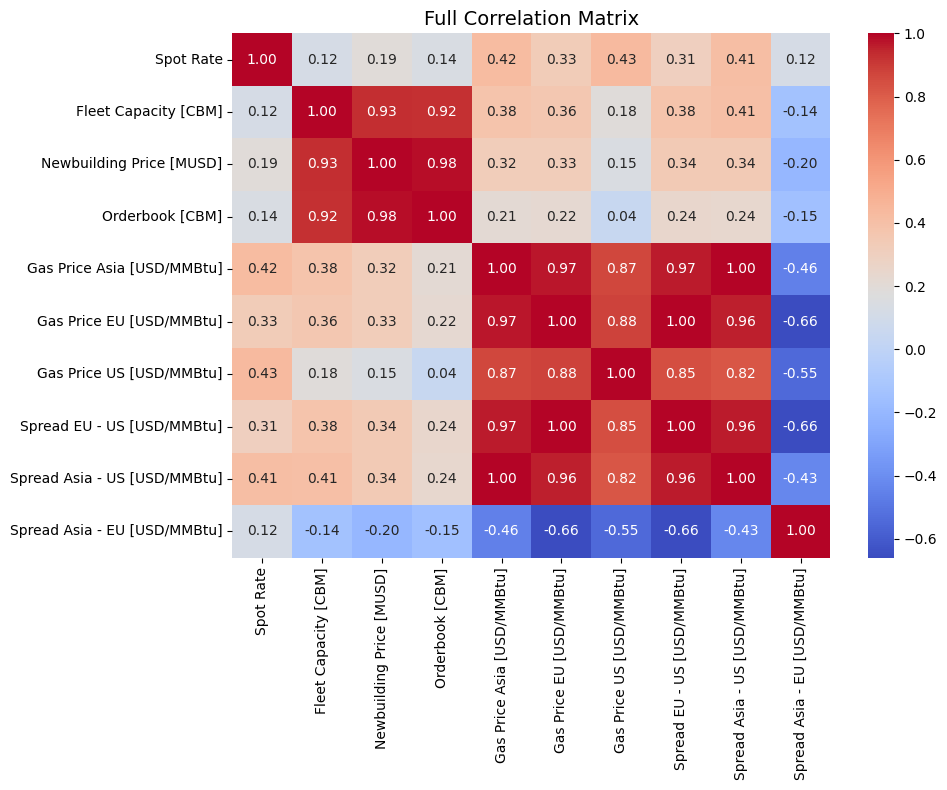

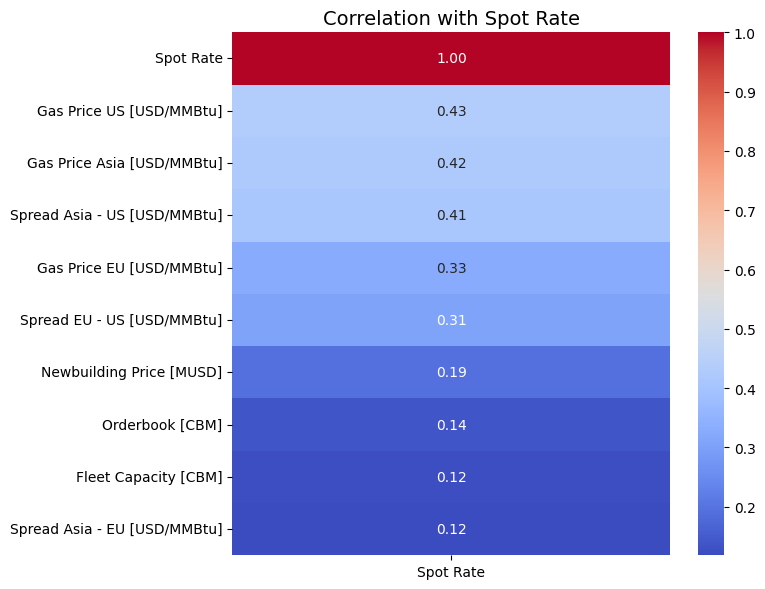

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("cleandata.csv")
df = df.rename(columns={
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 'Spot Rate',
    'LNG Shipping Capacity (CBM)': 'Fleet Capacity [CBM]',
    'LNG Carrier Newbuilding Prices (end month, $m)': 'Newbuilding Price [MUSD]',
    'LNG Orderbook (start month, CBM)': 'Orderbook [CBM]',
    'Global price of Natural Gas, Asia (start month, MMBTU)': 'Gas Price Asia [USD/MMBtu]',
    'Global price of Natural Gas, EU (start month, MMBTU)': 'Gas Price EU [USD/MMBtu]',
    'Global price of Natural Gas, US Henry Hub (start month, MMBTU)': 'Gas Price US [USD/MMBtu]',
    'Spread\nASIA-US': 'Spread Asia - US [USD/MMBtu]',
    'Spread\nEU-US': 'Spread EU - US [USD/MMBtu]',
    'Spread\nASIA-EU': 'Spread Asia - EU [USD/MMBtu]'
})

correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Full Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

correlations = correlation_matrix[['Spot Rate']].sort_values(by='Spot Rate', ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation with Spot Rate", fontsize=14)
plt.tight_layout()
plt.show()


<Axes: >

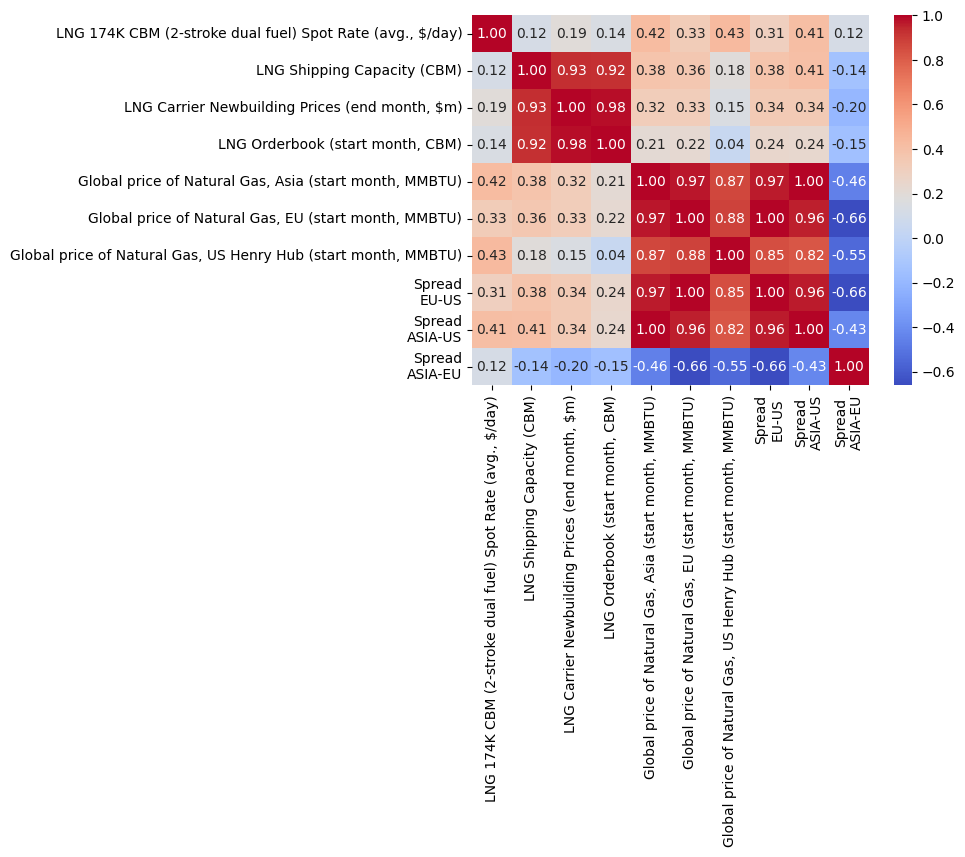

In [30]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

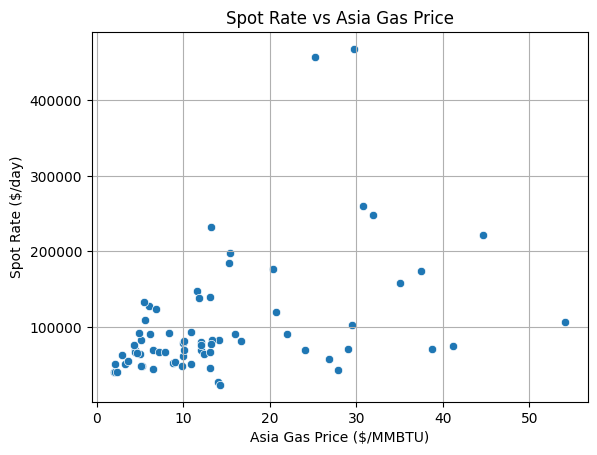

In [4]:
sns.scatterplot(x=df['Global price of Natural Gas, Asia (start month, MMBTU)'],
                y=df[target])
plt.title("Spot Rate vs Asia Gas Price")
plt.xlabel("Asia Gas Price ($/MMBTU)")
plt.ylabel("Spot Rate ($/day)")
plt.grid(True)
plt.show()


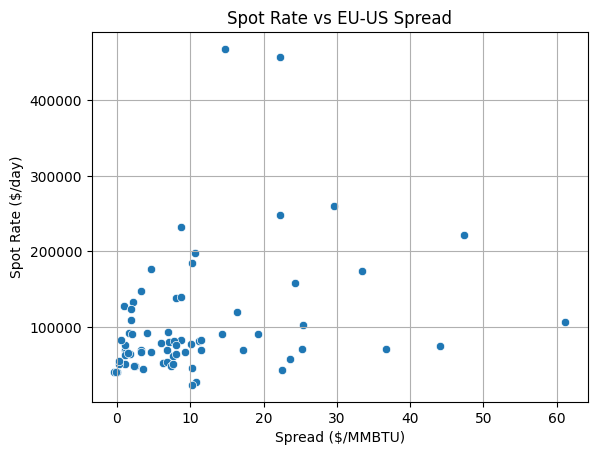

In [9]:
sns.scatterplot(x=df['Spread\nEU-US'],
                y=df[target])
plt.title("Spot Rate vs EU-US Spread")
plt.xlabel("Spread ($/MMBTU)")
plt.ylabel("Spot Rate ($/day)")
plt.grid(True)
plt.show()

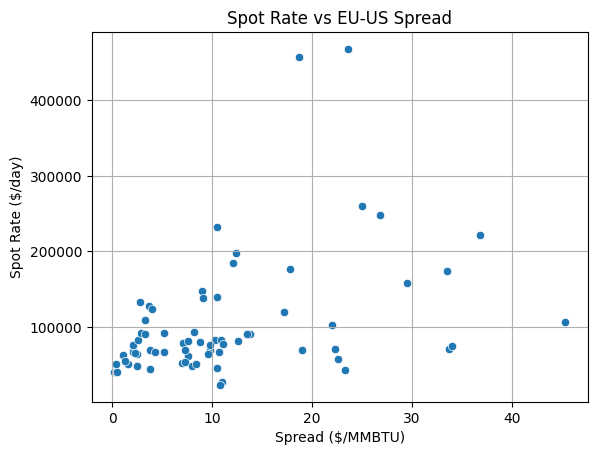

In [10]:
sns.scatterplot(x=df['Spread\nASIA-US'],
                y=df[target])
plt.title("Spot Rate vs EU-US Spread")
plt.xlabel("Spread ($/MMBTU)")
plt.ylabel("Spot Rate ($/day)")
plt.grid(True)
plt.show()

In [23]:
df_features=df
df_features['spot_rate_lag_1'] = df_features[target].shift(1)
df_features['spot_rate_lag_2'] = df_features[target].shift(2)
df_features['spot_rate_lag_3'] = df_features[target].shift(3)

df_features['spot_rate_roll3'] = df_features[target].rolling(window=3).mean()
df_features['spot_rate_roll6'] = df_features[target].rolling(window=6).mean()

df_features = df_features.dropna()



In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define features and target
target = 'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'
X = df_features.drop(columns=[target])
y = df_features[target]
# Use time series split for evaluation
tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Store metrics for each fold
mae_scores, rmse_scores = [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

avg_mae = np.mean(mae_scores)
avg_rmse = np.mean(rmse_scores)
print(mae_scores, rmse_scores)
avg_mae, avg_rmse


[29366.606534090908, 34839.041193181816, 81533.77485795454, 35378.42471590909, 25387.729758522728] [np.float64(37220.213050736624), np.float64(41510.64847499638), np.float64(125156.14593829072), np.float64(51699.62524847638), np.float64(29368.176820885554)]


(np.float64(41301.115411931816), np.float64(56990.961906677134))

In [20]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Date': y_test.index,
    'Actual Spot Rate': y_test.values,
    'Predicted Spot Rate': y_pred
}).set_index('Date')

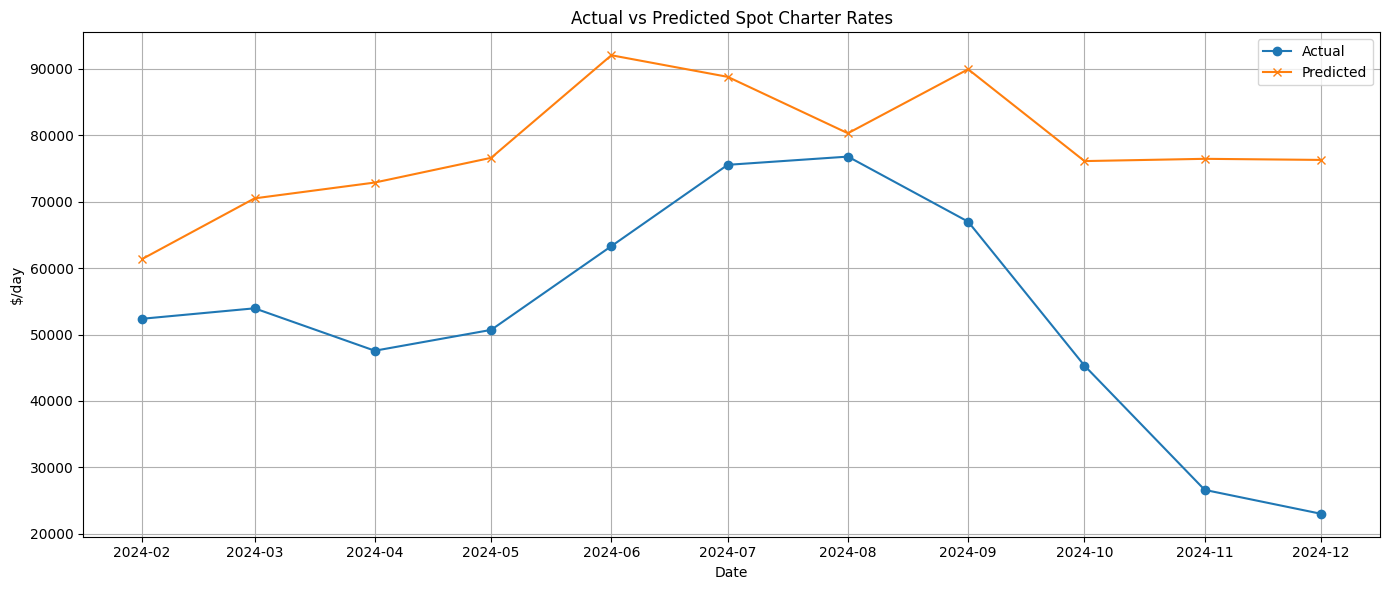

In [22]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(results.index, results['Actual Spot Rate'], label='Actual', marker='o')
plt.plot(results.index, results['Predicted Spot Rate'], label='Predicted', marker='x')
plt.title("Actual vs Predicted Spot Charter Rates")
plt.ylabel("$/day")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

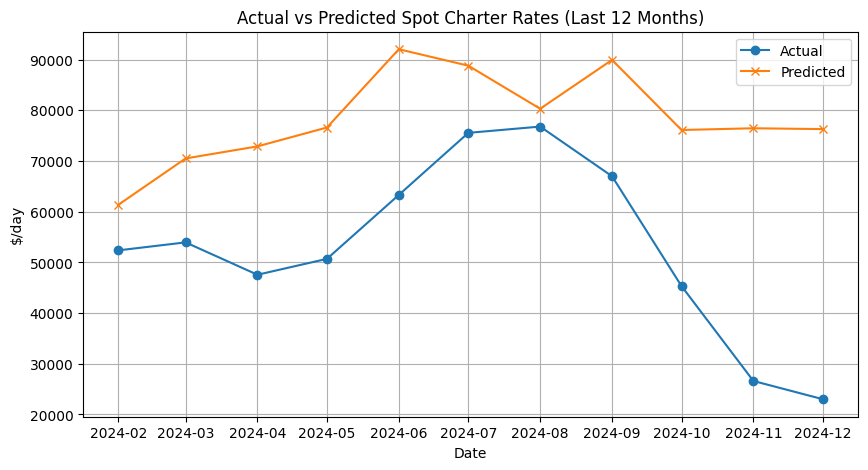

In [21]:
# Plot only the last 12 months for simplicity and memory efficiency
results_subset = results.tail(12)

plt.figure(figsize=(10, 5))
plt.plot(results_subset.index, results_subset['Actual Spot Rate'], label='Actual', marker='o')
plt.plot(results_subset.index, results_subset['Predicted Spot Rate'], label='Predicted', marker='x')
plt.title("Actual vs Predicted Spot Charter Rates (Last 12 Months)")
plt.ylabel("$/day")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()
